In [2]:
import numpy as np 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
import librosa
import librosa.display
import IPython.display as ipd
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers
from keras.models import Sequential
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard, ReduceLROnPlateau

import matplotlib.collections as collections
import matplotlib.patches as mpatches

# Функции для предобработки звука

In [3]:

def load_audio(AUDIO_PATH):
    audio, sr = librosa.load(AUDIO_PATH)
    return audio, sr

def wav2melSpec(AUDIO_PATH):
    audio, sr = librosa.load(AUDIO_PATH)
    return librosa.feature.melspectrogram(y=audio, sr=sr)

def imgSpec(ms_feature):
    fig, ax = plt.subplots()
    ms_dB = librosa.power_to_db(ms_feature, ref=np.max)
    #print(ms_feature.shape)
    img = librosa.display.specshow(ms_dB, x_axis='time', y_axis='mel', ax=ax)
    fig.colorbar(img, ax=ax, format='%+2.0f dB')
    ax.set(title='Mel-frequency spectrogram');
    
def hear_audio(AUDIO_PATH):
    audio, sr = librosa.load(AUDIO_PATH)
    #print("\t", end="")
    ipd.display(ipd.Audio(data=audio, rate=sr))
    
    
def get_audio_info(path, show_melspec=False, label=None):
    spec = wav2melSpec(path)
    if label is not None:
        pass
        #print("Label:", label)
    if show_melspec is not False:
        imgSpec(spec)
    hear_audio(path)

In [4]:
MFCC_NUM =  14
SAMPLING_RATE = 44100 
MFCC_MAX_LEN = 128 

def wav2mfcc(wave, max_len=MFCC_MAX_LEN):
    mfcc = librosa.feature.mfcc(y=wave, n_mfcc=MFCC_NUM, sr=SAMPLING_RATE)
    if (max_len > mfcc.shape[1]):
        pad_width = max_len - mfcc.shape[1]
        mfcc = np.pad(mfcc, pad_width=((0, 0), (0, pad_width)), mode='constant')

    else:
        mfcc = mfcc[:, :max_len]
    
    return mfcc

# Предобработка датасета

In [5]:
base_path = r"D:\python\safevision\SafeVision\breath detection\Breath_Dataset2"

SAMPLING_RATE = 7000  # Стандартная частота дискретизации для librosa 44100 было

# # Функция для получения MFCC спектрограммы
# def wav2mfcc(audio, sr=SAMPLING_RATE, n_mfcc=14):
#     # Вычисление MFCC спектрограммы
#     mfcc = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=n_mfcc)
#     return mfcc

mfcc_spectograms = []

classes = ['0', '1']

for class_label in classes:
    class_path = os.path.join(base_path, class_label)
    
    if os.path.exists(class_path):
        files_in_dir = os.listdir(class_path)
        
        for file_name in files_in_dir:
            if file_name.endswith('.wav'):
                try:
                    audio, _ = librosa.load(os.path.join(class_path, file_name), sr=SAMPLING_RATE)

                    spectrogram = np.expand_dims(wav2mfcc(audio), axis=-1)

                    mfcc_spectograms.append((spectrogram, int(class_label)))

                    audio_shifted = librosa.effects.pitch_shift(audio, sr=SAMPLING_RATE, n_steps=12)
                    spectrogram_shifted = np.expand_dims(wav2mfcc(audio_shifted), axis=-1)

                    mfcc_spectograms.append((spectrogram_shifted, int(class_label)))
                    
                    print(f"Processed file: {file_name} from class {class_label}")
                    
                except Exception as e:
                    print(f"Error processing file {file_name}: {e}")
    else:
        print(f"Class directory {class_path} does not exist.")

print(f"Total processed MFCC spectrograms: {len(mfcc_spectograms)}")

X = [x[0] for x in mfcc_spectograms]  # Спектрограммы
y = [x[1] for x in mfcc_spectograms]  # Метки классов

X = np.array(X)
y = np.array(y)


Processed file: 0_0.wav from class 0
Processed file: 0_1.wav from class 0
Processed file: 0_10.wav from class 0
Processed file: 0_100.wav from class 0
Processed file: 0_101.wav from class 0
Processed file: 0_102.wav from class 0
Processed file: 0_103.wav from class 0
Processed file: 0_104.wav from class 0
Processed file: 0_105.wav from class 0
Processed file: 0_106.wav from class 0
Processed file: 0_107.wav from class 0
Processed file: 0_108.wav from class 0
Processed file: 0_109.wav from class 0
Processed file: 0_11.wav from class 0
Processed file: 0_110.wav from class 0
Processed file: 0_111.wav from class 0
Processed file: 0_112.wav from class 0
Processed file: 0_113.wav from class 0
Processed file: 0_114.wav from class 0
Processed file: 0_115.wav from class 0
Processed file: 0_116.wav from class 0
Processed file: 0_117.wav from class 0
Processed file: 0_118.wav from class 0
Processed file: 0_119.wav from class 0
Processed file: 0_12.wav from class 0
Processed file: 0_120.wav from c

In [6]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

print("Shape of X_train:", X_train.shape)
print("Shape of X_test:", X_test.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of y_test:", y_test.shape)

Shape of X_train: (1211, 14, 128, 1)
Shape of X_test: (303, 14, 128, 1)
Shape of y_train: (1211,)
Shape of y_test: (303,)


# Модель

In [7]:
from tensorflow.keras import Sequential, layers

dropout = 0.3
input_dim = (14, 128, 1)  # Убедитесь, что это правильные размеры для ваших данных
output_dim_vocab = 1  # Мы изменили на 1 для двоичной классификации

model = Sequential([
    #1 layer
    layers.Conv2D(filters=32, kernel_size=[6, 6], strides=[2, 2], input_shape=input_dim, padding="same", use_bias=False),
    layers.BatchNormalization(),
    layers.Activation(activation='leaky_relu'),
    layers.MaxPooling2D(pool_size=(3, 3)),
    layers.Dropout(dropout),
    
    # 2 layer
    layers.Conv2D(128, (3, 3), padding='same'),
    layers.BatchNormalization(),
    layers.Activation(activation='relu'),
    layers.Dropout(dropout),
    
    # 3 conv layer
    layers.Conv2D(512, (3, 3), padding='same'),
    layers.BatchNormalization(),
    layers.Activation(activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Dropout(dropout),
    
    # 4 conv layer
    layers.Conv2D(512, (3, 3), padding='same'),
    layers.BatchNormalization(),
    layers.Activation(activation='relu'),
    layers.Dropout(dropout),
    
    layers.Flatten(),
    
    # Fully connected layer
    layers.Dense(256, activation="relu"),
    layers.Dropout(dropout),
    
    # Output layer
    layers.Dense(1, activation="sigmoid"),
])

In [8]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [9]:
model_path = 'D:\python\safevision\SafeVision/breath detection\models'

earlystopper = EarlyStopping(monitor='val_loss', patience=20, verbose=1, mode='min')
checkpoint = ModelCheckpoint(f"{model_path}/model_cpu.h5", monitor='val_loss', verbose=1, save_best_only=True, mode='min')
tb_callback = TensorBoard(f'{model_path}/logs', update_freq=1)
reduceLROnPlat = ReduceLROnPlateau(monitor='val_loss', factor=0.8, min_delta=1e-10, patience=3, verbose=1, mode='auto')

In [9]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 7, 64, 32)         1152      
                                                                 
 batch_normalization (Batch  (None, 7, 64, 32)         128       
 Normalization)                                                  
                                                                 
 activation (Activation)     (None, 7, 64, 32)         0         
                                                                 
 max_pooling2d (MaxPooling2  (None, 2, 21, 32)         0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 2, 21, 32)         0         
                                                                 
 conv2d_1 (Conv2D)           (None, 2, 21, 128)        3

# Обучение

In [10]:
history = model.fit(
    x=X_train,
    y=y_train,
    validation_split=0.1,
    epochs=25, #Original is 50
    batch_size=64,
    callbacks=[earlystopper, checkpoint, reduceLROnPlat, tb_callback]
)

Epoch 1/25
18/18 [==============================] - ETA: 0s - loss: 1.1000 - accuracy: 0.7107
Epoch 1: val_loss improved from inf to 3.86113, saving model to D:\python\safevision\SafeVision/breath detection\models\model_cpu.h5
18/18 [==============================] - 9s 376ms/step - loss: 1.1000 - accuracy: 0.7107 - val_loss: 3.8611 - val_accuracy: 0.3689 - lr: 0.0010
Epoch 2/25


d:\python\safevision\.safevision\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


18/18 [==============================] - ETA: 0s - loss: 0.3904 - accuracy: 0.8522
Epoch 2: val_loss improved from 3.86113 to 0.81937, saving model to D:\python\safevision\SafeVision/breath detection\models\model_cpu.h5
18/18 [==============================] - 8s 424ms/step - loss: 0.3904 - accuracy: 0.8522 - val_loss: 0.8194 - val_accuracy: 0.4672 - lr: 0.0010
Epoch 3/25
17/18 [===========================>..] - ETA: 0s - loss: 0.2789 - accuracy: 0.8879
Epoch 3: val_loss improved from 0.81937 to 0.39654, saving model to D:\python\safevision\SafeVision/breath detection\models\model_cpu.h5
18/18 [==============================] - 7s 370ms/step - loss: 0.2794 - accuracy: 0.8871 - val_loss: 0.3965 - val_accuracy: 0.7951 - lr: 0.0010
Epoch 4/25
17/18 [===========================>..] - ETA: 0s - loss: 0.2341 - accuracy: 0.9145
Epoch 4: val_loss improved from 0.39654 to 0.20203, saving model to D:\python\safevision\SafeVision/breath detection\models\model_cpu.h5
18/18 [=======================

KeyboardInterrupt: 

In [11]:
MODEL_PATH = r'D:\python\safevision\SafeVision\breath detection\models\h5\model_BIG_DATASET_3.h5'

In [2]:
model.save("MODEL_PATH")

NameError: name 'model' is not defined

# Загрузка и тестирование модели

In [12]:
from tensorflow.keras.models import load_model

MODEL_PATH = r'D:\python\safevision\SafeVision\breath detection\models\h5\model_BIG_DATASET_2.h5'
model = load_model(MODEL_PATH)

In [37]:
# Оценка модели на тестовом наборе данных
test_loss, test_accuracy = model.evaluate(X_test, y_test, batch_size=26)

print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")


437/437 [==============================] - 11s 24ms/step - loss: 0.0271 - accuracy: 0.9920
Test Loss: 0.02707710862159729
Test Accuracy: 0.9919745922088623


In [13]:
def preprocess_audio(file_path):
    # Загрузка аудиофайла
    wave, sr = librosa.load(file_path, sr=SAMPLING_RATE)
    
    # Проверка длины
    if len(wave) == 0:
        raise ValueError("Аудиофайл пуст.")
    
    # Преобразование в MFCC
    mfcc = wav2mfcc(wave)
    
    # Добавление измерения для batch_size
    return np.expand_dims(mfcc, axis=0)  # Форма: (1, MFCC_NUM, MFCC_MAX_LEN)


In [14]:
def predict_from_file(file_path):
    # Предобработка аудиофайла
    input_data = preprocess_audio(file_path)
    
    # Предсказание
    prediction = model.predict(input_data, )
    
    # Возвращаем результат
    return prediction


In [17]:
files_path = r'D:\python\safevision\SafeVision\breath detection\Breath_Dataset2\0/'

predictions = []

for file_name in os.listdir(files_path):
    file_path = files_path + file_name
    prediction = predict_from_file(file_path)
    prediction = 1 if prediction > 0.5 else 0
    predictions.append(prediction)

1/1 [==============================] - 0s 26ms/step


In [18]:
print(sum(predictions))

174


# Окно в пять секунд, с перекрытием

In [19]:
def predict_for_segments(segments, model):
    predictions = []
    for i, segment in enumerate(segments):
        mfcc = wav2mfcc(segment)
        
        input_data = np.expand_dims(mfcc, axis=0)

        prediction = model.predict(input_data)
        predictions.append(prediction)
    
    return predictions

In [16]:
def split_audio(file_path, window_duration=5.0, segment_duration=1.0, step_size=0.5):
    wave, sr = librosa.load(file_path, sr=SAMPLING_RATE)
    
    window_length = int(sr * window_duration)
    segment_length = int(sr * segment_duration)
    step = int(sr * step_size)

    segments = []
    segments_in_windows = []

    for start in range(0, len(wave) - window_length + 1, step):
        window = wave[start:start + window_length]
        segments_in_window = []
        
        for i in range(0, len(window) - segment_length + 1, segment_length):
            segment = window[i:i + segment_length]
            segments.append(segment)
            segments_in_window.append(segment)

        segments_in_windows.append(segments_in_window)
    
    return segments_in_windows


In [17]:
def visual_signal(segments, yhat):
    fig, ax = plt.subplots()
    plt.rcParams['figure.figsize'] = (14,5)

    x = np.linspace(0, len(segments) * 1.0, len(segments))

    for i, segment in enumerate(segments):
        segment_time = np.linspace(i, i + 1, len(segment))
        ax.plot(segment_time, segment, linewidth=0.5)

    for i in range(len(yhat)):
        x_start = i
        x_end = i + 1

        yrange = (4*10000, -6*10000)
        
        color = 'green' if yhat[i] == 1 else 'red'
        alpha = 0.2
        
        c = collections.BrokenBarHCollection(
            [(x_start, x_end - x_start)], yrange, facecolor=color, alpha=alpha
        )
        ax.add_collection(c)

    red_patch = mpatches.Patch(color='red', label='Not Breath', alpha=0.2)
    green_patch = mpatches.Patch(color='green', label='Breath', alpha=0.2)

    leg1 = ax.legend(labels=['Audio recording WAV file'], loc=1)
    leg2 = ax.legend(handles=[red_patch, green_patch], loc=4)

    ax.add_artist(leg1)
    ax.add_artist(leg2)

    plt.xlabel('Time(Sec)')
    plt.ylabel('Amplitude')
    plt.show()

1/1 [==============================] - 0s 26ms/step
Сегмент 1: класс 1, вероятности [0.97718245]
Сегмент 2: класс 1, вероятности [0.7730754]
Сегмент 3: класс 1, вероятности [0.99382854]
Сегмент 4: класс 1, вероятности [0.99861556]
Сегмент 5: класс 1, вероятности [0.8848309]


C:\Temp\ipykernel_3444\3471345085.py:20: MatplotlibDeprecationWarning: The BrokenBarHCollection class was deprecated in Matplotlib 3.7 and will be removed two minor releases later.
  c = collections.BrokenBarHCollection(


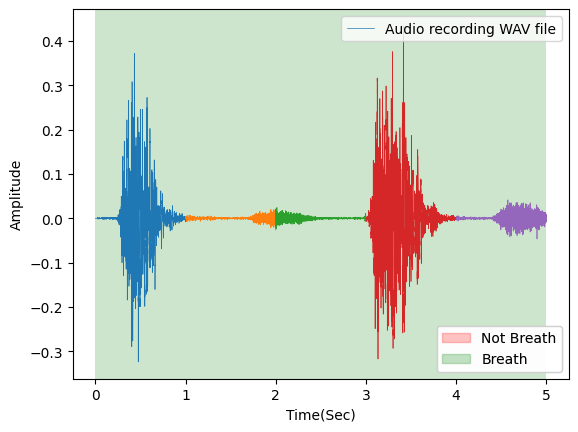

1/1 [==============================] - 0s 32ms/step
Сегмент 1: класс 0, вероятности [0.3018787]
Сегмент 2: класс 1, вероятности [0.9984267]
Сегмент 3: класс 0, вероятности [0.08911863]
Сегмент 4: класс 1, вероятности [0.6260088]
Сегмент 5: класс 1, вероятности [0.9998211]


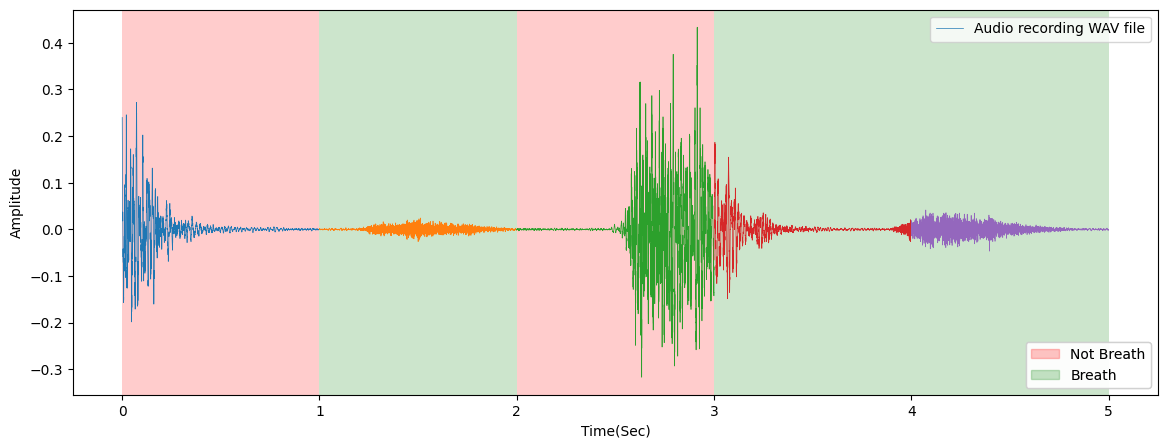

1/1 [==============================] - 0s 29ms/step
Сегмент 1: класс 1, вероятности [0.7730754]
Сегмент 2: класс 1, вероятности [0.99382854]
Сегмент 3: класс 1, вероятности [0.99861556]
Сегмент 4: класс 1, вероятности [0.8848309]
Сегмент 5: класс 1, вероятности [0.97613555]


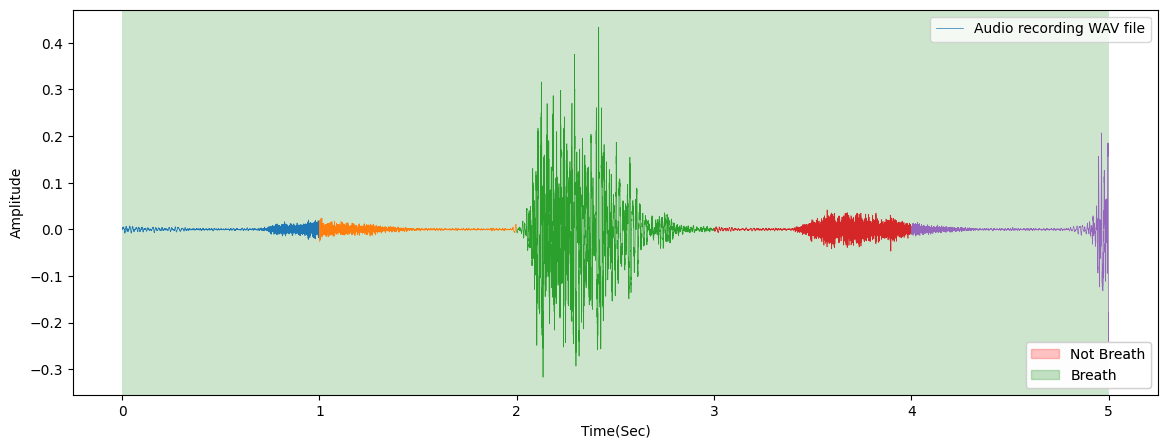

1/1 [==============================] - 0s 28ms/step
Сегмент 1: класс 1, вероятности [0.9984267]
Сегмент 2: класс 0, вероятности [0.08911863]
Сегмент 3: класс 1, вероятности [0.6260088]
Сегмент 4: класс 1, вероятности [0.9998211]
Сегмент 5: класс 0, вероятности [0.03605893]


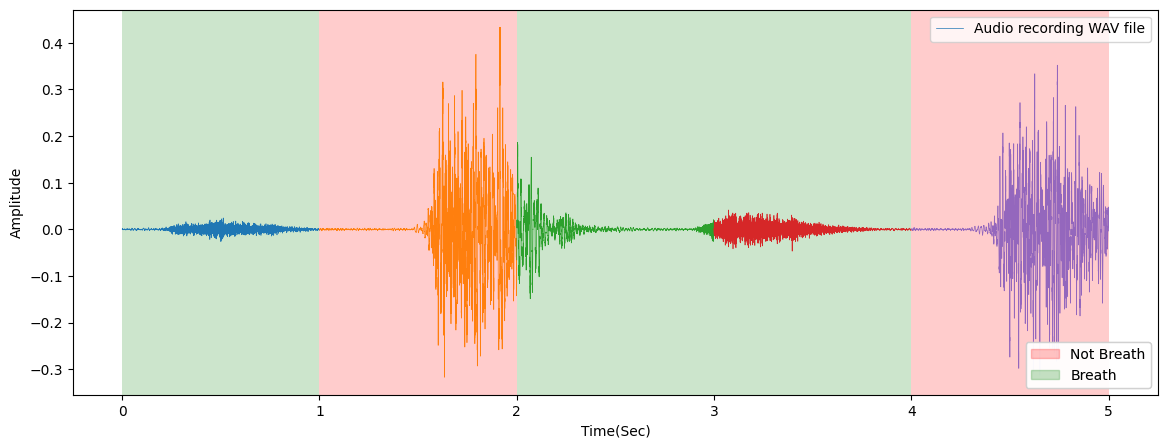

1/1 [==============================] - 0s 33ms/step
Сегмент 1: класс 1, вероятности [0.99382854]
Сегмент 2: класс 1, вероятности [0.99861556]
Сегмент 3: класс 1, вероятности [0.8848309]
Сегмент 4: класс 1, вероятности [0.97613555]
Сегмент 5: класс 1, вероятности [0.9345636]


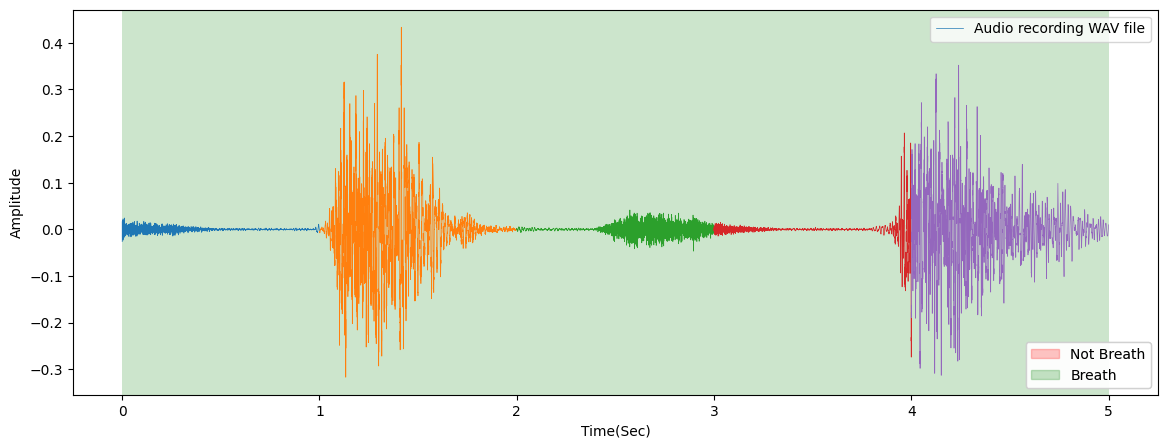

1/1 [==============================] - 0s 31ms/step
Сегмент 1: класс 0, вероятности [0.08911863]
Сегмент 2: класс 1, вероятности [0.6260088]
Сегмент 3: класс 1, вероятности [0.9998211]
Сегмент 4: класс 0, вероятности [0.03605893]
Сегмент 5: класс 1, вероятности [0.87511784]


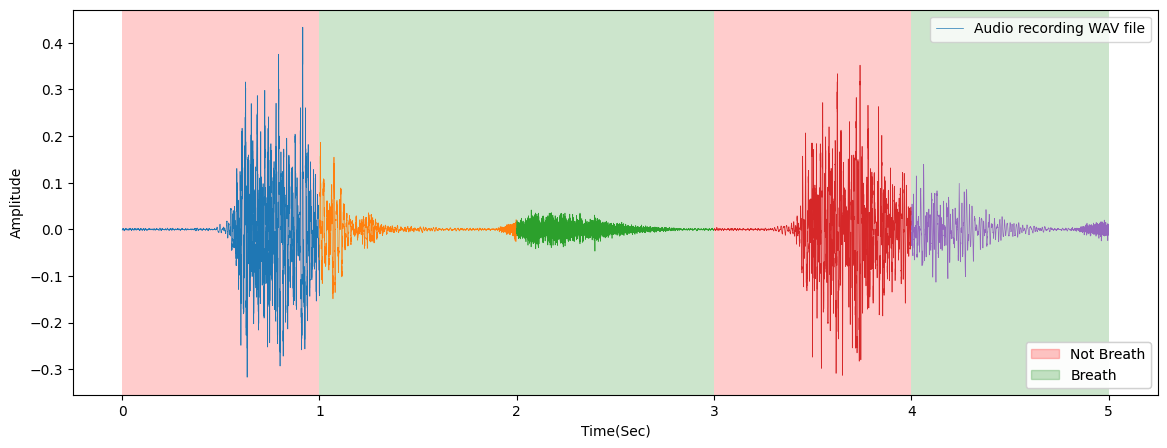

1/1 [==============================] - 0s 25ms/step
Сегмент 1: класс 1, вероятности [0.99861556]
Сегмент 2: класс 1, вероятности [0.8848309]
Сегмент 3: класс 1, вероятности [0.97613555]
Сегмент 4: класс 1, вероятности [0.9345636]
Сегмент 5: класс 0, вероятности [0.0485018]


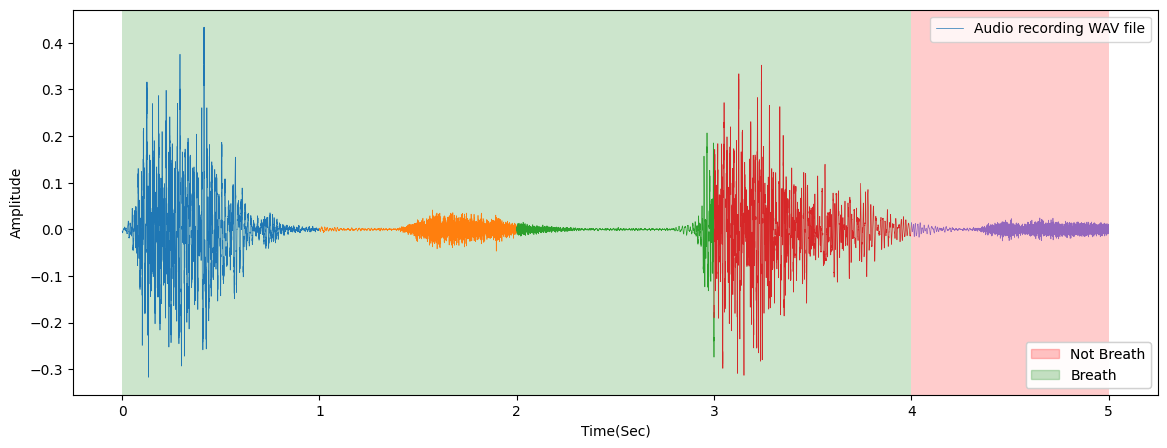

1/1 [==============================] - 0s 31ms/step
Сегмент 1: класс 1, вероятности [0.6260088]
Сегмент 2: класс 1, вероятности [0.9998211]
Сегмент 3: класс 0, вероятности [0.03605893]
Сегмент 4: класс 1, вероятности [0.87511784]
Сегмент 5: класс 1, вероятности [0.99988246]


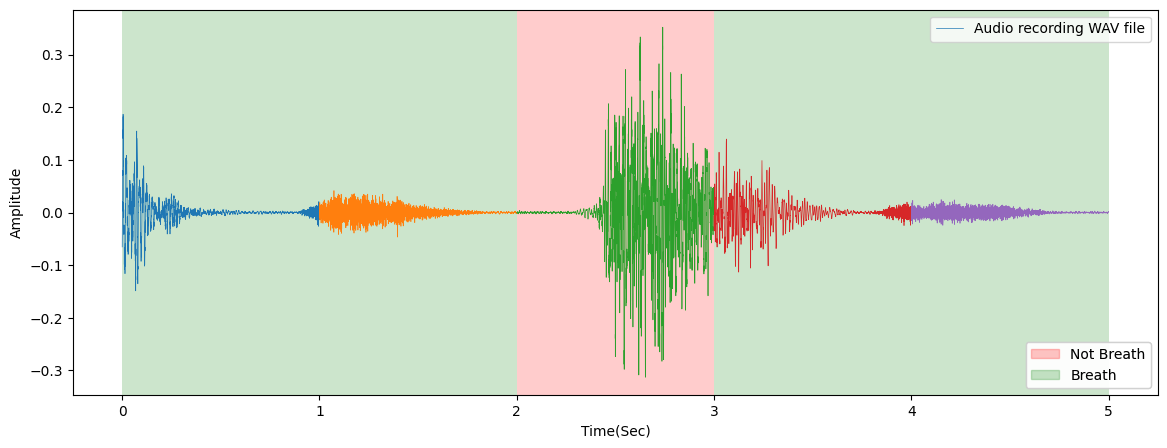

1/1 [==============================] - 0s 27ms/step
Сегмент 1: класс 1, вероятности [0.8848309]
Сегмент 2: класс 1, вероятности [0.97613555]
Сегмент 3: класс 1, вероятности [0.9345636]
Сегмент 4: класс 0, вероятности [0.0485018]
Сегмент 5: класс 1, вероятности [0.7231629]


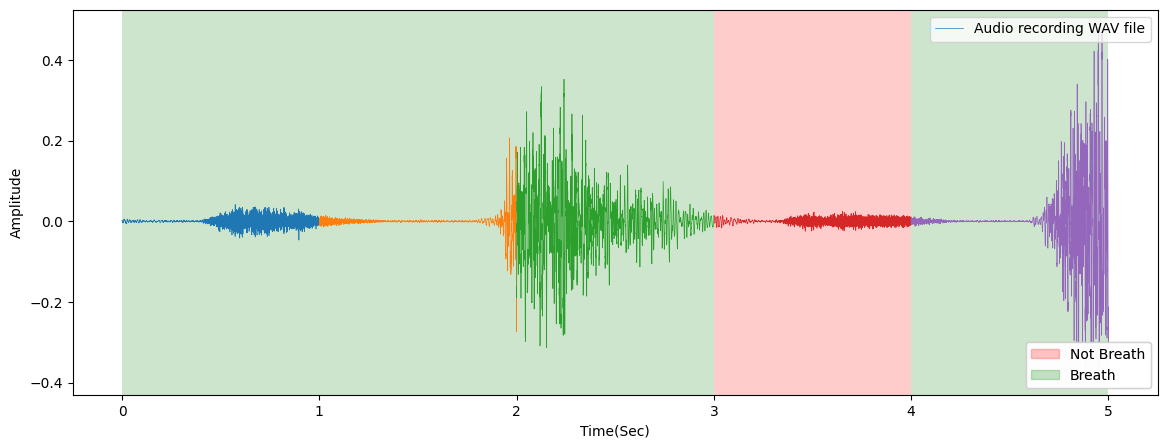

1/1 [==============================] - 0s 32ms/step
Сегмент 1: класс 1, вероятности [0.9998211]
Сегмент 2: класс 0, вероятности [0.03605893]
Сегмент 3: класс 1, вероятности [0.87511784]
Сегмент 4: класс 1, вероятности [0.99988246]
Сегмент 5: класс 1, вероятности [0.9750177]


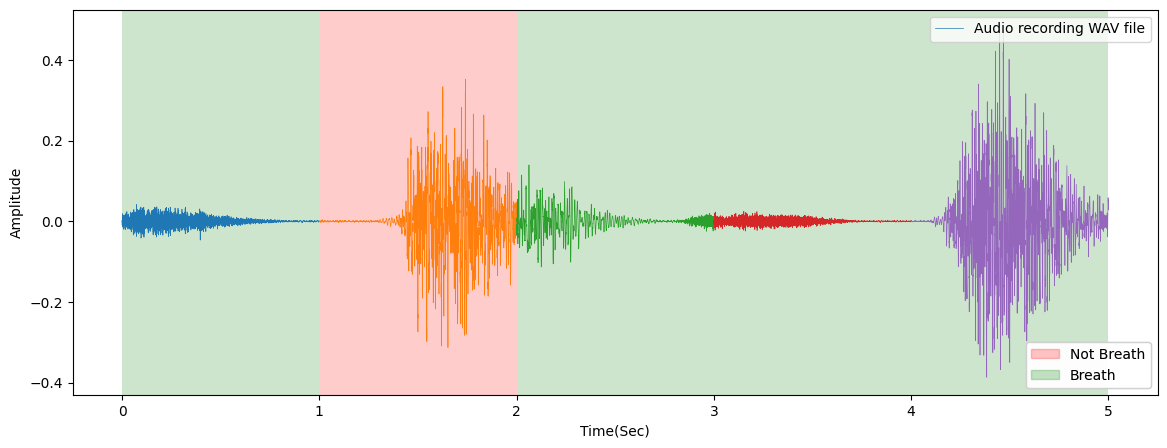

1/1 [==============================] - 0s 31ms/step
Сегмент 1: класс 1, вероятности [0.97613555]
Сегмент 2: класс 1, вероятности [0.9345636]
Сегмент 3: класс 0, вероятности [0.0485018]
Сегмент 4: класс 1, вероятности [0.7231629]
Сегмент 5: класс 1, вероятности [0.82398826]


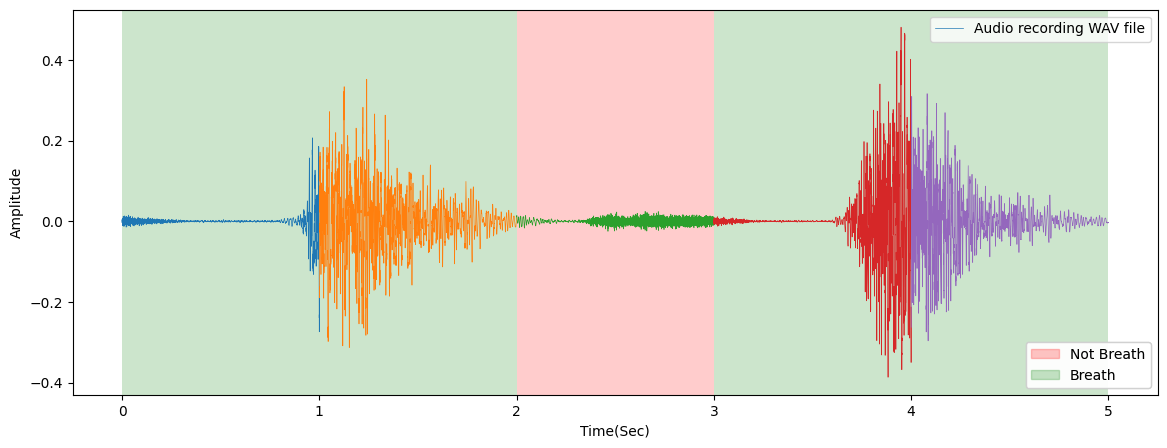

1/1 [==============================] - 0s 28ms/step
Сегмент 1: класс 0, вероятности [0.03605893]
Сегмент 2: класс 1, вероятности [0.87511784]
Сегмент 3: класс 1, вероятности [0.99988246]
Сегмент 4: класс 1, вероятности [0.9750177]
Сегмент 5: класс 0, вероятности [0.11598826]


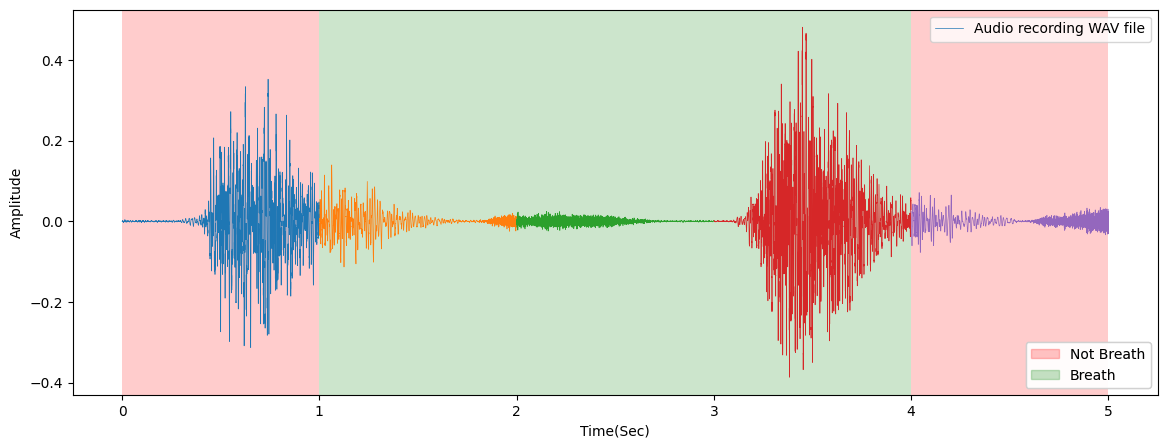

1/1 [==============================] - 0s 35ms/step
Сегмент 1: класс 1, вероятности [0.9345636]
Сегмент 2: класс 0, вероятности [0.0485018]
Сегмент 3: класс 1, вероятности [0.7231629]
Сегмент 4: класс 1, вероятности [0.82398826]
Сегмент 5: класс 1, вероятности [0.97087306]


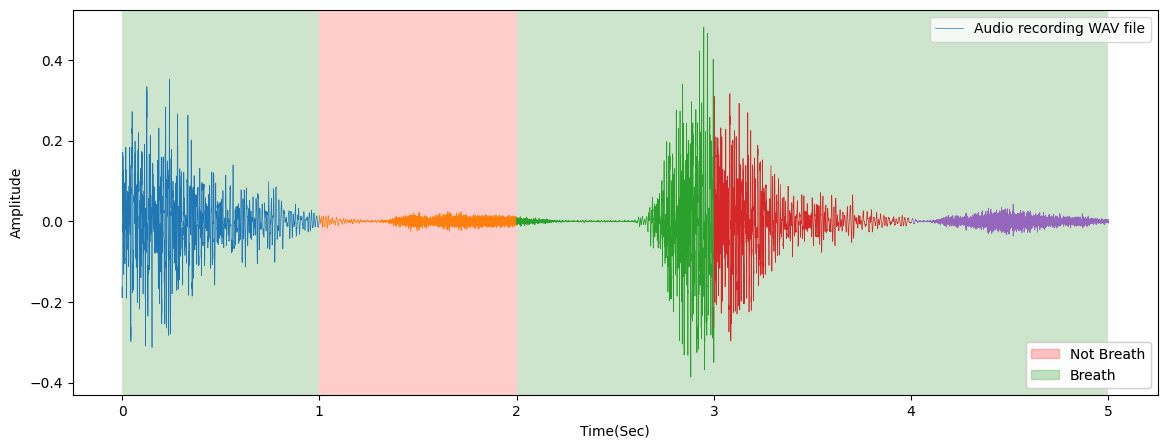

1/1 [==============================] - 0s 28ms/step
Сегмент 1: класс 1, вероятности [0.87511784]
Сегмент 2: класс 1, вероятности [0.99988246]
Сегмент 3: класс 1, вероятности [0.9750177]
Сегмент 4: класс 0, вероятности [0.11598826]
Сегмент 5: класс 1, вероятности [0.9994916]


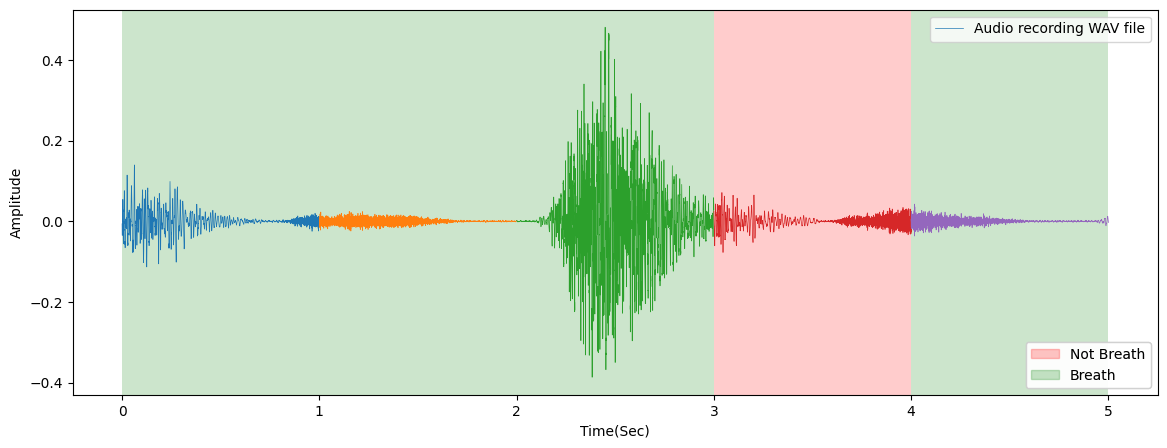

1/1 [==============================] - 0s 38ms/step
Сегмент 1: класс 0, вероятности [0.0485018]
Сегмент 2: класс 1, вероятности [0.7231629]
Сегмент 3: класс 1, вероятности [0.82398826]
Сегмент 4: класс 1, вероятности [0.97087306]
Сегмент 5: класс 0, вероятности [0.22729042]


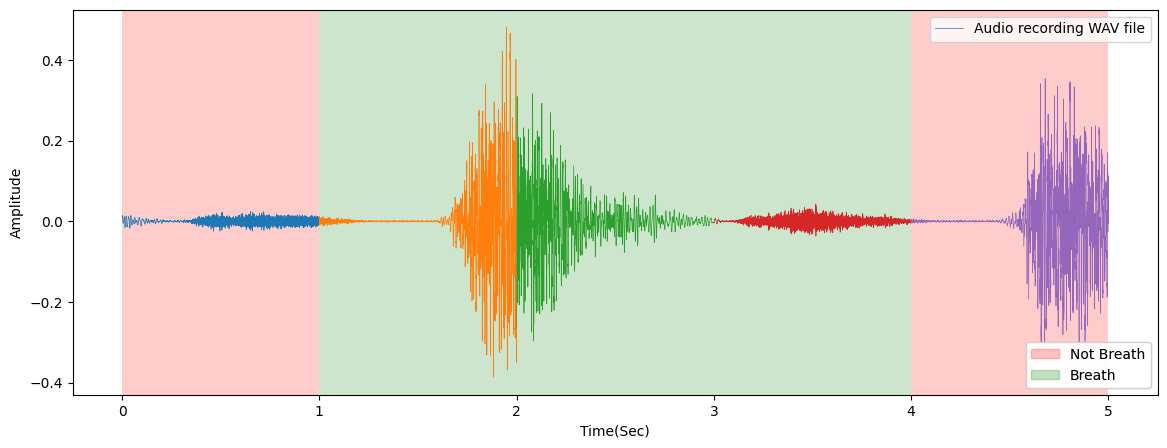

1/1 [==============================] - 0s 29ms/step
Сегмент 1: класс 1, вероятности [0.99988246]
Сегмент 2: класс 1, вероятности [0.9750177]
Сегмент 3: класс 0, вероятности [0.11598826]
Сегмент 4: класс 1, вероятности [0.9994916]
Сегмент 5: класс 1, вероятности [0.99847037]


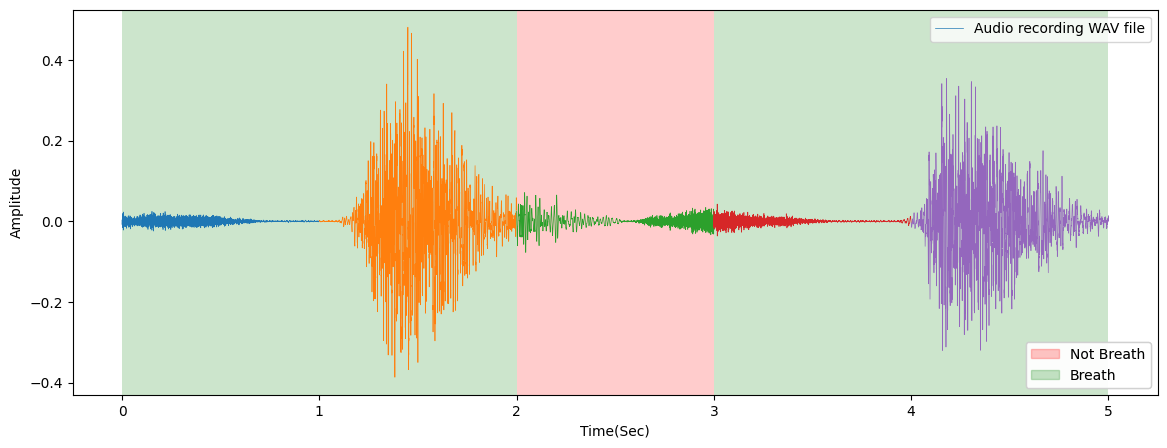

1/1 [==============================] - 0s 46ms/step
Сегмент 1: класс 1, вероятности [0.7231629]
Сегмент 2: класс 1, вероятности [0.82398826]
Сегмент 3: класс 1, вероятности [0.97087306]
Сегмент 4: класс 0, вероятности [0.22729042]
Сегмент 5: класс 0, вероятности [0.06550378]


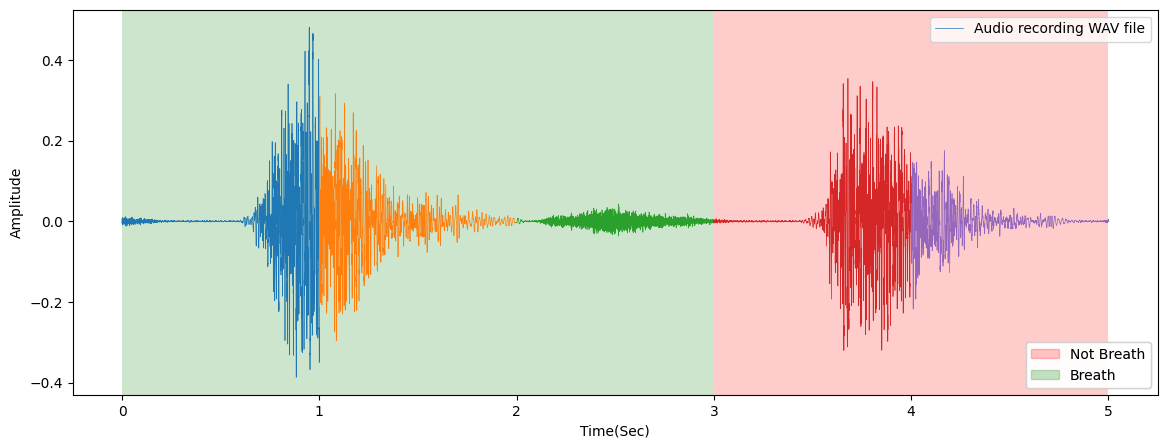

1/1 [==============================] - 0s 69ms/step


KeyboardInterrupt: 

In [18]:
file_path = r"D:\python\safevision\SafeVision\breath detection\Sounds_for_cute\old\05a6c56143d0263.mp3"

segments = split_audio(file_path)

for segment in segments:
    predictions = predict_for_segments(segment, model)
    yhat = []

    for i, prediction in enumerate(predictions):
        predicted_class = 1 if prediction[0] > 0.9 else 0
        yhat.append(predicted_class)
        print(f"Сегмент {i + 1}: класс {predicted_class}, вероятности {prediction[0]}")

    visual_signal(segment, yhat)

# Разделение на отрезки длиной 1, без перекрытия

In [31]:
# Функция для разделения на отрезки
def split_audio_into_segments(audio_file, segment_duration=1.0):
    # Загрузка аудиофайла
    audio, sr = librosa.load(audio_file, sr=None)  # sr=None чтобы сохранить оригинальную частоту дискретизации
    
    # Определение длины сегмента в сэмплах
    segment_length = int(segment_duration * sr)
    
    # Разбиение на сегменты
    segments = []
    for start in range(0, len(audio), segment_length):
        end = start + segment_length
        segment = audio[start:end]
        segments.append(segment)
        
    return segments, sr

# Функция для предсказания на каждом сегменте
def predict_for_segments(segments, model):
    predictions = []
    for i, segment in enumerate(segments):
        # Извлечение MFCC для каждого сегмента
        mfcc = wav2mfcc(segment)  # Замените на ваш способ извлечения MFCC

        # Подготовка данных для модели
        input_data = np.expand_dims(mfcc, axis=0)
        
        # Предсказание
        prediction = model.predict(input_data)
        prediction = 1 if prediction > 0.5 else 0
        predictions.append(prediction)
    
    return predictions

# Основная часть программы
def predict_audio_file(audio_file, model):
    # Разбиение аудио на 1-секундные сегменты
    segments, sr = split_audio_into_segments(audio_file, segment_duration=1.0)
    
    # Предсказания для каждого сегмента
    predictions = predict_for_segments(segments, model)
    
    return predictions, segments


In [32]:
FILE_PATH = r'D:\python\safevision\SafeVision\breath detection\Sounds_for_cute\old\05a6c56143d0263.mp3'
pred, seg = predict_audio_file(FILE_PATH, model)

1/1 [==============================] - 0s 25ms/step


In [30]:
print(pred)

[1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0]


# Разделение на отрезки с наложением

In [23]:
# Функция для разделения аудио на пересекающиеся сегменты
def split_audio_into_segments(audio_file, segment_duration=1.0, overlap_duration=0.5):
    # Загрузка аудиофайла
    audio, sr = librosa.load(audio_file, sr=None)  # sr=None сохраняет оригинальную частоту дискретизации
    
    # Определение длины сегмента и перекрытия в сэмплах
    segment_length = int(segment_duration * sr)
    overlap_length = int(overlap_duration * sr)
    
    segments = []
    for start in range(0, len(audio) - segment_length + 1, overlap_length):
        end = start + segment_length
        segment = audio[start:end]
        segments.append(segment)
        
    return segments, sr

# Функция для предсказания на каждом сегменте
def predict_for_segments(segments, model):
    predictions = []
    for i, segment in enumerate(segments):
        # Извлечение MFCC для каждого сегмента
        mfcc = wav2mfcc(segment)  # Замените на ваш способ извлечения MFCC

        # Подготовка данных для модели
        input_data = np.expand_dims(mfcc, axis=0)
        
        # Предсказание
        prediction = model.predict(input_data)
        prediction = 1 if prediction > 0.5 else 0
        predictions.append(prediction)
    
    return predictions

# Основная часть программы
def predict_audio_file(audio_file, model):
    # Разбиение аудио на 1-секундные сегменты с перекрытием 0.5 секунды
    segments, sr = split_audio_into_segments(audio_file, segment_duration=1.0, overlap_duration=0.5)
    
    # Предсказания для каждого сегмента
    predictions = predict_for_segments(segments, model)
    
    return predictions, segments


In [24]:
FILE_PATH = r'D:\python\safevision\SafeVision\breath detection\Sounds_for_cute\old\05a6c56143d0263.mp3'
pred, seg = predict_audio_file(FILE_PATH, model)

1/1 [==============================] - 0s 28ms/step


In [25]:
print(pred)

[1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1]


In [26]:
def visual_signal(segments, yhat):
    fig, ax = plt.subplots()
    plt.rcParams['figure.figsize'] = (14,5)

    x = np.linspace(0, len(segments) * 1.0, len(segments))

    for i, segment in enumerate(segments):
        segment_time = np.linspace(i, i + 1, len(segment))
        ax.plot(segment_time, segment, linewidth=0.5)

    for i in range(len(yhat)):
        x_start = i
        x_end = i + 1

        yrange = (4*10000, -6*10000)
        
        color = 'green' if yhat[i] == 1 else 'red'
        alpha = 0.2
        
        c = collections.BrokenBarHCollection(
            [(x_start, x_end - x_start)], yrange, facecolor=color, alpha=alpha
        )
        ax.add_collection(c)

    red_patch = mpatches.Patch(color='red', label='Not Breath', alpha=0.2)
    green_patch = mpatches.Patch(color='green', label='Breath', alpha=0.2)

    leg1 = ax.legend(labels=['Audio recording WAV file'], loc=1)
    leg2 = ax.legend(handles=[red_patch, green_patch], loc=4)

    ax.add_artist(leg1)
    ax.add_artist(leg2)

    plt.xlabel('Time(Sec)')
    plt.ylabel('Amplitude')
    plt.show()

C:\Temp\ipykernel_12016\3471345085.py:20: MatplotlibDeprecationWarning: The BrokenBarHCollection class was deprecated in Matplotlib 3.7 and will be removed two minor releases later.
  c = collections.BrokenBarHCollection(


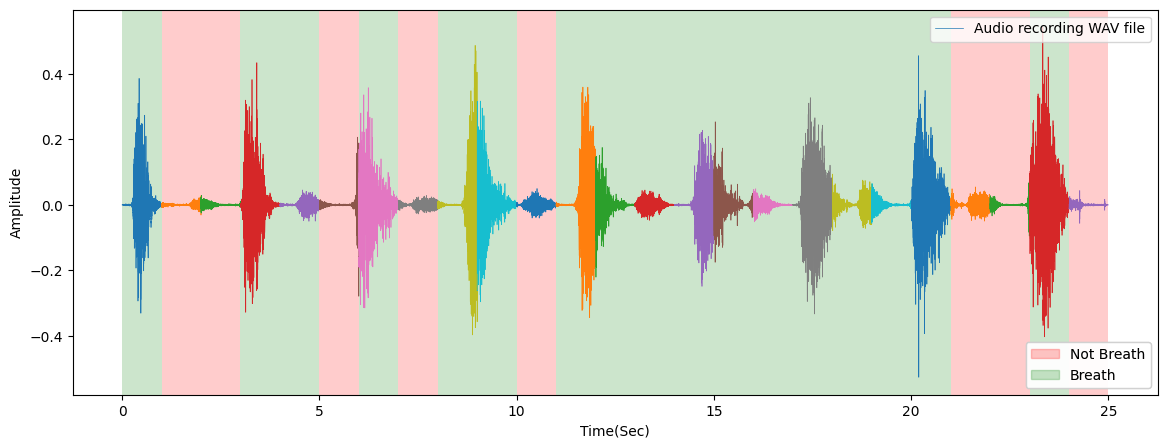

In [33]:
visual_signal(seg, pred)